In [1]:
import tensorflow as tf
import pickle
import uncertainties.unumpy as unp
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/TopWorkshop22'
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DRll01","Mll01","DEtall_SS","jet_pseudoscore_DL1r0","jet_pseudoscore_DL1r1","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_final.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DRll01
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r0
Ignoring feature:  jet_pseudoscore_DL1r1
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 16 features on the dataset 8 features were loaded: 

DPhill_SS
HT_jets
HT_lep
MtLepMet
jet_pt0_nofwd
met_met
nJets_OR
sumPsbtag
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Dataset contains 253953 Signal events and 1425994 Background events.


In [3]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes']
[0 1 2 3 4 5 6 7 8]


In [4]:
Phi = input_features[:,0]
Phi_background = Phi[class_labels!=0]
input_features = input_features[:,1:8]

In [5]:
input_features = input_features[class_labels!=0]

In [6]:
scaler = pickle.load(open(path_tosave + '/scaler.pkl','rb'))
ScaleWeights(targets,weights)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=1152.66, W(0)=2983.69
Scaled weights:: W(1)=839974, W(0)=839974


In [7]:
model=Load_Model(path_tosave)

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/TopWorkshop22/architecture.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/TopWorkshop22/weights.h5)


In [8]:
inp_bck_Phi_larger2 = input_scaled[Phi_background >= 2.0]
inp_bck_Phi_smaller2 = input_scaled[Phi_background < 2.0]

In [9]:
NN_Out = model.predict(input_scaled)
NN_Out_larger2 = model.predict(inp_bck_Phi_larger2)
NN_Out_smaller2 = model.predict(inp_bck_Phi_smaller2)

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [10]:
def Calc_Bin_Center(bins):
    bin_centers = np.zeros([bins.size-1])
    for i in range(bins.size-1):
        bin_centers[i] = (bins[i] + bins[i+1])/2
    return bin_centers

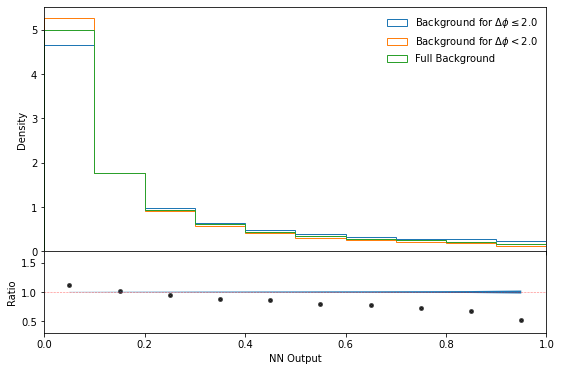

In [15]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(9,6), gridspec_kw={'height_ratios': [3, 1]})
histargs = {"bins":10, "range":(0,1.), "density":True, "histtype":'step'}
list0 = axs[0].hist(NN_Out_larger2, label=r"Background for $\Delta \phi \leq 2.0$", **histargs)
list1 = axs[0].hist(NN_Out_smaller2, label=r"Background for $\Delta \phi < 2.0$", **histargs)
axs[0].hist(NN_Out, label=r"Full Background", **histargs)
bin_centers = Calc_Bin_Center(list0[1])
##Errorbars
bin_entries_n, _ = np.histogram(NN_Out_larger2, bins=10, range=(0,1), density=True)
bin_entries, _ = np.histogram(NN_Out_larger2, bins=10, range=(0,1))
scale_factor = np.mean(bin_entries / bin_entries_n)
error = np.sqrt(bin_entries) / scale_factor
L2 = unp.uarray(bin_entries_n, error)
bin_entries_n, _ = np.histogram(NN_Out_smaller2, bins=10, range=(0,1), density=True)
bin_entries, _ = np.histogram(NN_Out_smaller2, bins=10, range=(0,1))
scale_factor = np.mean(bin_entries / bin_entries_n)
error = np.sqrt(bin_entries) / scale_factor
S2 = unp.uarray(bin_entries_n, error)
Ratio_errors = unp.std_devs(L2/S2)
#axs[0].set_yscale('log')
axs[0].set_ylabel("Density")
#axs[0].set_xlabel(r"NN Output")
axs[0].legend(frameon=False)
Frac = list1[0]/list0[0]
axs[1].scatter(bin_centers, Frac, marker='.', linewidth=2, color='black', alpha=0.7)
axs[1].set_ylabel(r"Ratio")
axs[1].set_ylim(0.3,1.7)
axs[1].hlines(1, -0.1, 1.1, alpha=0.5, linestyle='--', color='red', linewidth=0.6)
axs[1].fill_between(bin_centers, 1-Ratio_errors, 1+Ratio_errors)
#axs[1].grid()
plt.subplots_adjust(hspace=0)
plt.xlim(0,1)
plt.xlabel(r"NN Output")
plt.savefig('Background_compare.pdf')

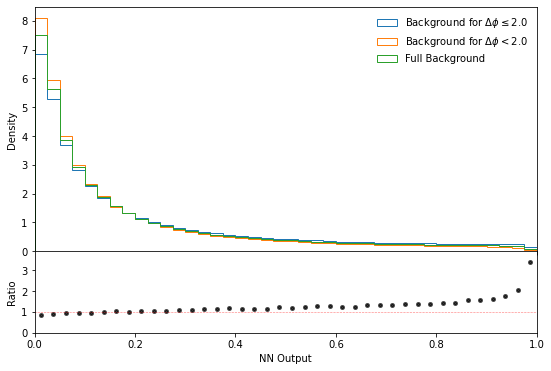

In [12]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(9,6), gridspec_kw={'height_ratios': [3, 1]})
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
list0 = axs[0].hist(NN_Out_larger2, label=r"Background for $\Delta \phi \leq 2.0$", **histargs)
list1 = axs[0].hist(NN_Out_smaller2, label=r"Background for $\Delta \phi < 2.0$", **histargs)
axs[0].hist(NN_Out, label=r"Full Background", **histargs)
#axs[0].set_yscale('log')
axs[0].set_ylabel("Density")
#axs[0].set_xlabel(r"NN Output")
axs[0].legend(frameon=False)
bin_centers = Calc_Bin_Center(list0[1])
Frac = list0[0]/list1[0]
axs[1].scatter(bin_centers, Frac, marker='.', linewidth=2, color='black', alpha=0.7)
axs[1].set_ylabel(r"Ratio")
axs[1].set_ylim(0,3.9)
axs[1].hlines(1, -0.1, 1.1, alpha=0.5, linestyle='--', color='red', linewidth=0.6)
#axs[1].grid()
plt.subplots_adjust(hspace=0)
plt.xlim(0,1)
plt.xlabel(r"NN Output")
plt.savefig('Background_Linear_compare.pdf')